In [1]:
from Imports import *
from Helper import *
from Preprocessing import *
from Plotting import *

%matplotlib inline

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
jet_images_path = '../data/jet-images_Mass60-100_pT250-300_R1.25_Pix25.hdf5'
jet_mass_data = HDF5File(jet_images_path, 'r')

print(jet_mass_data.keys())
print(jet_mass_data['image'].shape)

<KeysViewHDF5 ['image', 'jet_delta_R', 'jet_eta', 'jet_mass', 'jet_phi', 'jet_pt', 'signal', 'tau_1', 'tau_2', 'tau_21', 'tau_3', 'tau_32']>
(872666, 25, 25)


In [3]:
class Generator(nn.Module):
    def __init__(self, latent_dim=256):
        super().__init__()
        self.latent_dim = latent_dim

        self.noise = GaussianNoise(sigma=0.3)

        self.feature_gen = nn.Sequential(
            nn.Linear(9, 256),
            nn.LayerNorm(256),
            self.noise
        )

        self.image_gen1 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 1x1 → 2x2
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Dropout(0.2),
        )
        self.image_gen2 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # 2x2 → 4x4
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Dropout(0.2),
        )
        self.image_gen3 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),     # 4x4 → 8x8
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Dropout(0.2),
        )

        self.image_gen4 = nn.Sequential(
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),     # 8x8 → 16x16
            nn.Sigmoid()
        )

    def forward(self, z_feat):
        img = self.feature_gen(z_feat)
        # print(img.shape)
        img = img.view(-1, 256, 1, 1)
        # print(img.shape)
        img = self.image_gen1(img)
        # print(img.shape)
        img = self.image_gen2(img)
        # print(img.shape)
        img = self.image_gen3(img)
        # print(img.shape)
        img = self.image_gen4(img)
        # print(img.shape)
        img = soft_threshold(img, threshold=0.001, sharpness=1000.0)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Flattened image: 16x16 = 256
        self.image_encoder = nn.Sequential(
            spectral_norm(nn.Conv2d(1, 64, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            spectral_norm(nn.Conv2d(64, 128, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            spectral_norm(nn.Conv2d(128, 256, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            nn.Flatten()
        )

        self.feature_encoder = nn.Sequential(
            nn.Linear(4, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
        )

        # Dynamically get input dimensions
        with torch.no_grad():
            dummy = torch.zeros(1, 1, 16, 16)
            flat_dim = self.image_encoder(dummy).shape[1] + 64

        # Combined classifier
        self.classifier = nn.Sequential(
            nn.Linear(flat_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(256, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, img, features):
        img_encoded = self.image_encoder(img)
        feat_encoded = self.feature_encoder(features)
        combined = torch.cat((img_encoded, feat_encoded), dim=1)

        # print(img_encoded.shape)
        # print(feat_encoded.shape)
        # print(combined.shape[-1])

        prob = self.classifier(combined)

        return prob  # Shape: (batch_size, 1)

Image shape: torch.Size([87266, 16, 16])
dR Mean: torch.Size([87266])
dR STD: torch.Size([87266])
Pixel Mean: torch.Size([87266])
Pixel STD: torch.Size([87266])
ΔR min: 0.0
ΔR max: 2.203810453414917
ΔR mean min: 0.003941118251532316
ΔR mean max: 0.0156550332903862
ΔR std min: 0.020212490111589432
ΔR std max: 0.14540068805217743
Weights (pixel intensity) min: 0.0
Weights (pixel intensity) max: 1.0
Pixel mean min: 0.0028264394495636225
Pixel mean max: 0.00432002916932106
Pixel std min: 0.009188652969896793
Pixel std max: 0.06249340996146202


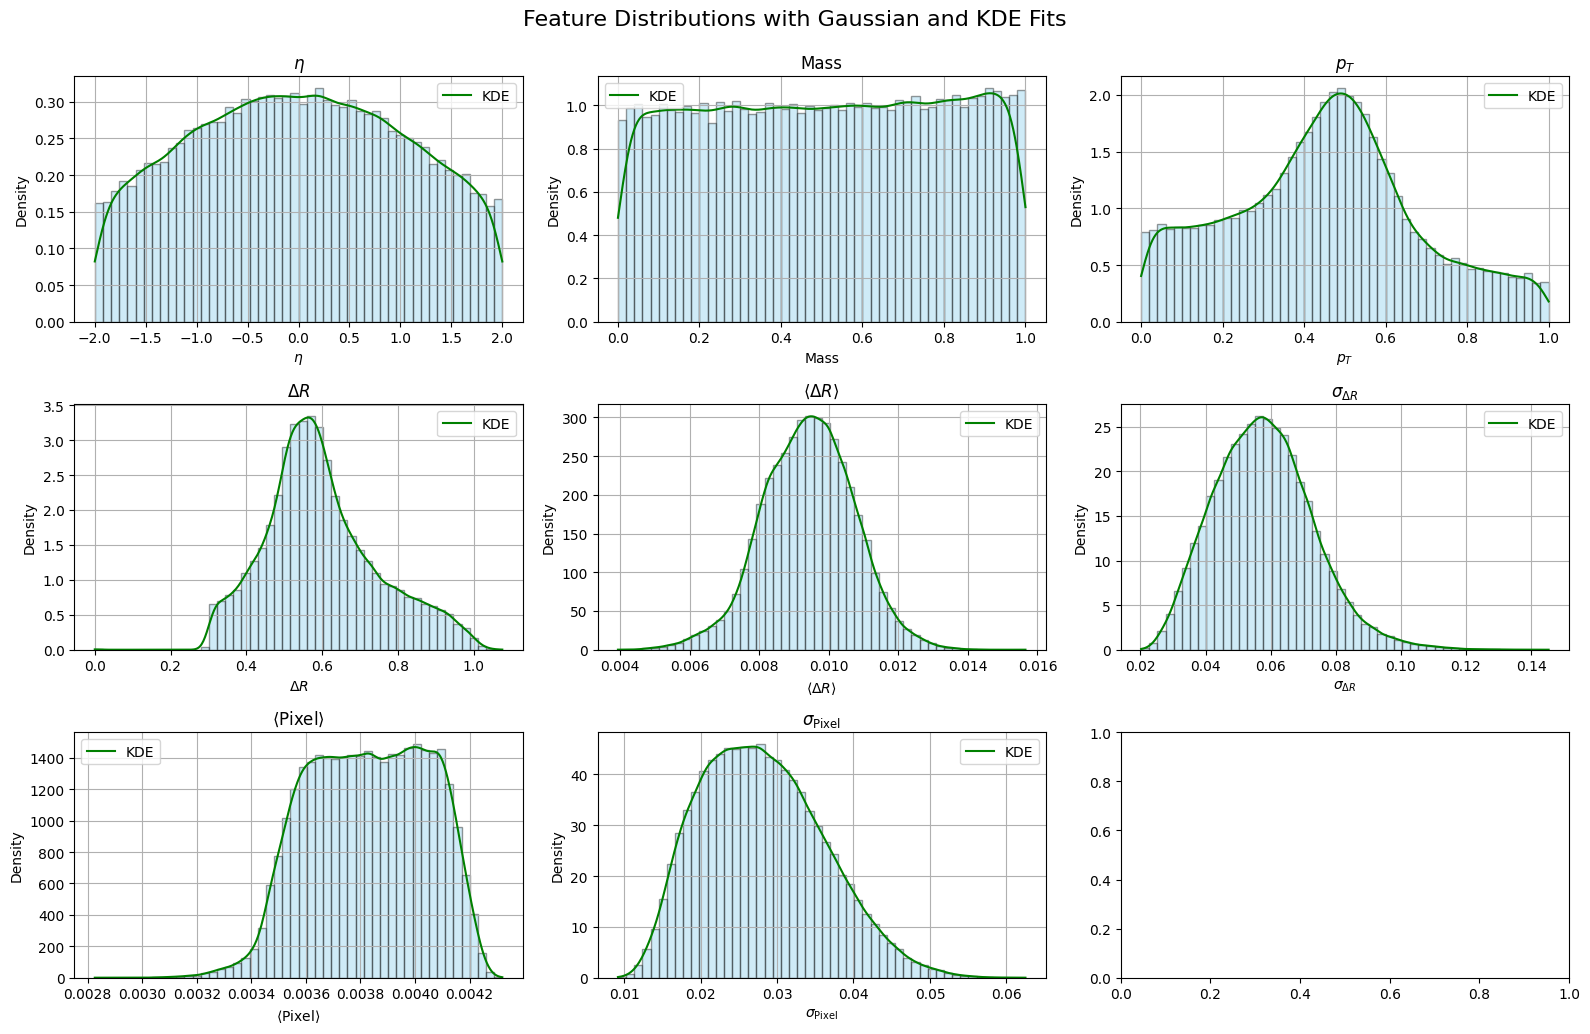

Number of samples: 87266
Image shape: torch.Size([87266, 16, 16])
Feature shape: torch.Size([87266, 9])


In [4]:
batch_size = 128*3
n_events = int(.1 * jet_mass_data['image'].shape[0])

dataset = JetDataset(jet_mass_data, n_events)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

kdes = feature_distributions(dataset)

print("Number of samples:", len(dataset))
print("Image shape:", dataset.images.shape)
print("Feature shape:", dataset.features.shape)

In [10]:
latent_dim = 256
lr = 10e-5
n_epochs = 30
num = 4

generator = Generator(latent_dim).cuda()
discriminator = Discriminator().cuda()

optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.9, 0.999))
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.9, 0.999))

g_losses = []
d_losses = []

# Image shape: (16, 16)
H, W = (16, 16)
center_x, center_y = (W - 1) / 2, (H - 1) / 2

# Coordinate grid
x_coords, y_coords = torch.meshgrid(
    torch.arange(W, dtype=torch.float32),
    torch.arange(H, dtype=torch.float32),
    indexing='ij')

# Distance from center
dists = (torch.sqrt((x_coords - center_x) ** 2 + (y_coords - center_y) ** 2)).cuda()
dists = dists.unsqueeze(0)  # [1, 16, 16]

tracked_fake_dR_mean = []
tracked_fake_dR_std = []
tracked_fake_pixel_mean = []
tracked_fake_pixel_std = []

tracked_real_dR_mean = []
tracked_real_dR_std = []
tracked_real_pixel_mean = []
tracked_real_pixel_std = []

In [12]:
## Load a previous model
# Replace with the desired filename
load_path = "models/class_gan_model_20250712_224355.pt"

# Load the checkpoint
checkpoint = torch.load(load_path)

# Restore model weights
generator.load_state_dict(checkpoint["generator_state_dict"])
discriminator.load_state_dict(checkpoint["discriminator_state_dict"])

# Optionally restore tracking data
g_losses = checkpoint["g_losses"]
d_losses = checkpoint["d_losses"]

tracked_fake_dR_mean = checkpoint["tracked_fake_dR_mean"]
tracked_fake_dR_std = checkpoint["tracked_fake_dR_std"]
tracked_fake_pixel_mean = checkpoint["tracked_fake_pixel_mean"]
tracked_fake_pixel_std = checkpoint["tracked_fake_pixel_std"]

tracked_real_dR_mean = checkpoint["tracked_real_dR_mean"]
tracked_real_dR_std = checkpoint["tracked_real_dR_std"]
tracked_real_pixel_mean = checkpoint["tracked_real_pixel_mean"]
tracked_real_pixel_std = checkpoint["tracked_real_pixel_std"]

print(f"Loaded model from {load_path}")

Loaded model from models/class_gan_model_20250712_224355.pt


[Epoch 1/30] [D loss: 0.6625] [G loss: 0.2234] [Validity_loss: 0.2096] 
 [Stat_loss: 0.1199] [NNZ_loss: 0.0179]
Sample feature coding: [ 0.         -0.7345929   0.49387705  0.39576805  0.47155255  0.00884811
  0.06055974  0.00383342  0.03315864]


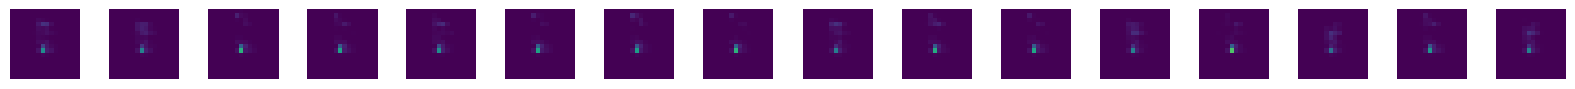

[Epoch 2/30] [D loss: 0.5276] [G loss: 0.2857] [Validity_loss: 0.2258] 
 [Stat_loss: 0.0455] [NNZ_loss: 0.0116]
Sample feature coding: [ 1.         -1.7075511   0.92074734  0.7341081   0.93020326  0.00941508
  0.07739598  0.00359391  0.0300535 ]


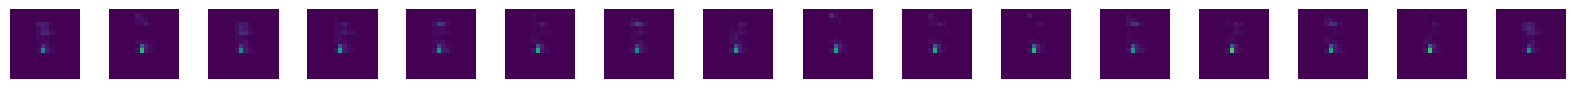

[Epoch 3/30] [D loss: 0.5557] [G loss: 0.2226] [Validity_loss: 0.2619] 
 [Stat_loss: 0.0454] [NNZ_loss: 0.0112]
Sample feature coding: [0.         0.6685702  0.24831675 0.756223   0.5310797  0.01010547
 0.08510877 0.00356453 0.02336764]


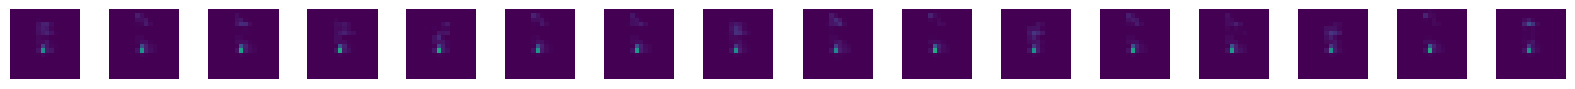

[Epoch 4/30] [D loss: 0.4887] [G loss: 0.2773] [Validity_loss: 0.3103] 
 [Stat_loss: 0.0506] [NNZ_loss: 0.0128]
Sample feature coding: [ 0.         -0.10642026  0.52277327  0.17314996  0.5300816   0.00796896
  0.0697471   0.00410471  0.03946177]


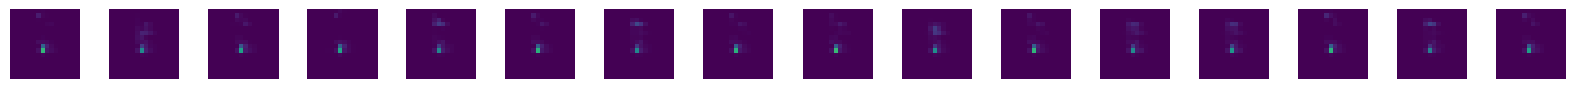

[Epoch 5/30] [D loss: 0.8409] [G loss: 0.3936] [Validity_loss: 0.3082] 
 [Stat_loss: 0.0455] [NNZ_loss: 0.0132]
Sample feature coding: [1.         0.07167426 0.06229491 0.75688946 0.4628539  0.00890274
 0.06490749 0.00401492 0.03303029]


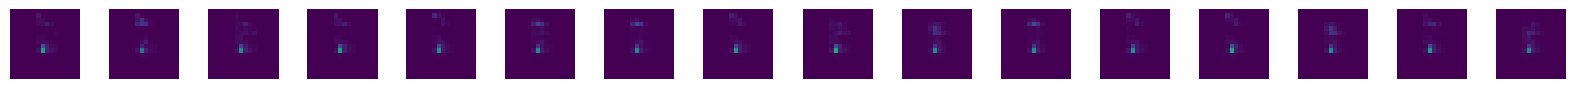

[Epoch 6/30] [D loss: 0.5952] [G loss: 0.3664] [Validity_loss: 0.3306] 
 [Stat_loss: 0.0454] [NNZ_loss: 0.0130]
Sample feature coding: [0.         0.04236086 0.06560063 0.5707575  0.5034028  0.01040278
 0.05813889 0.00354691 0.03109618]


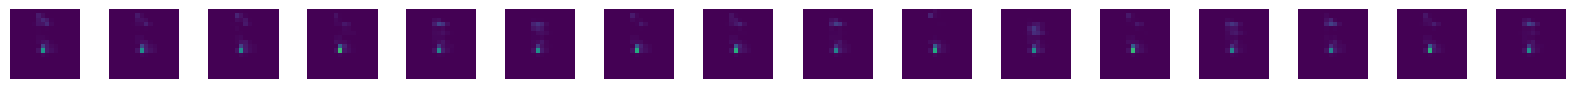

[Epoch 7/30] [D loss: 0.4852] [G loss: 0.2741] [Validity_loss: 0.3538] 
 [Stat_loss: 0.0454] [NNZ_loss: 0.0122]
Sample feature coding: [ 1.         -1.5372572   0.03988606  0.49180084  0.5457334   0.01130938
  0.03096257  0.00355555  0.01649829]


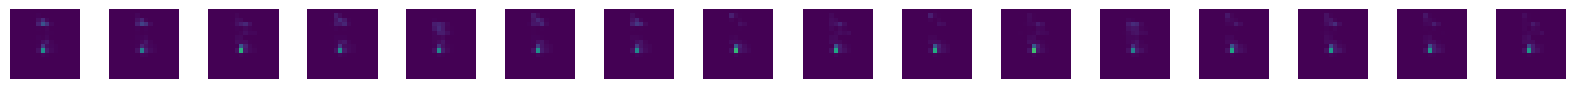

[Epoch 8/30] [D loss: 0.6296] [G loss: 0.2254] [Validity_loss: 0.3445] 
 [Stat_loss: 0.0454] [NNZ_loss: 0.0126]
Sample feature coding: [ 0.         -1.578144    0.91702145  0.27648294  0.67062706  0.01024756
  0.06762134  0.00392955  0.034301  ]


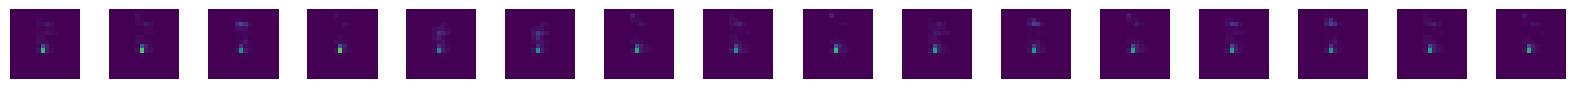

[Epoch 9/30] [D loss: 0.5798] [G loss: 0.3304] [Validity_loss: 0.3415] 
 [Stat_loss: 0.0453] [NNZ_loss: 0.0125]
Sample feature coding: [ 1.         -0.8044519   0.48245814  0.48913872  0.527208    0.00816095
  0.06828164  0.0035677   0.02027759]


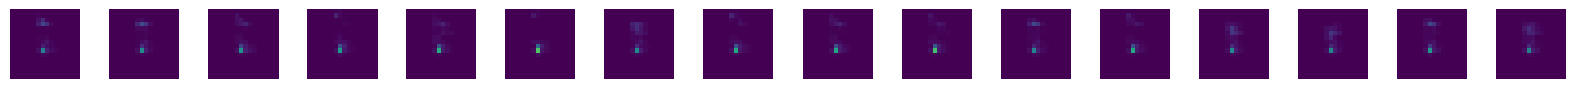

[Epoch 10/30] [D loss: 0.5532] [G loss: 0.2471] [Validity_loss: 0.3850] 
 [Stat_loss: 0.0454] [NNZ_loss: 0.0124]
Sample feature coding: [ 1.         -0.2549204   0.8306827   0.9151824   0.63333184  0.00926295
  0.06953793  0.00408354  0.02842887]


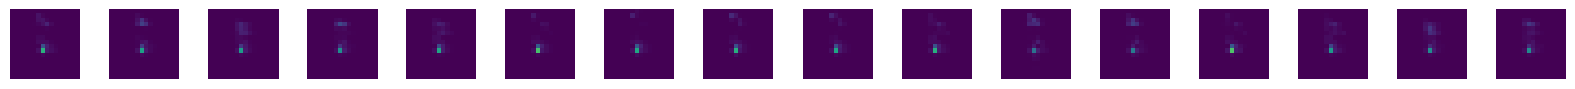

[Epoch 11/30] [D loss: 0.5480] [G loss: 0.6118] [Validity_loss: 0.3981] 
 [Stat_loss: 0.0457] [NNZ_loss: 0.0119]
Sample feature coding: [ 0.         -0.49935696  0.9273664   0.7303901   0.7915171   0.00893248
  0.05848249  0.00423451  0.03079277]


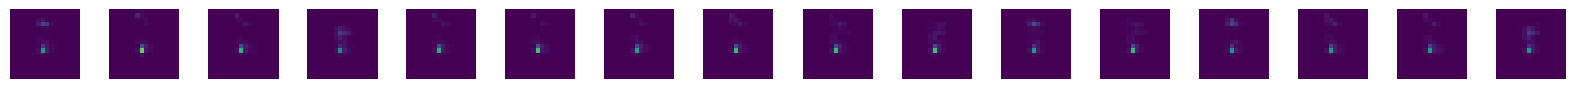

[Epoch 12/30] [D loss: 0.5768] [G loss: 0.2307] [Validity_loss: 0.3778] 
 [Stat_loss: 0.0454] [NNZ_loss: 0.0120]
Sample feature coding: [ 1.         -1.7108743   0.7268639   0.34873506  0.39851478  0.00942034
  0.09019449  0.00376553  0.04458825]


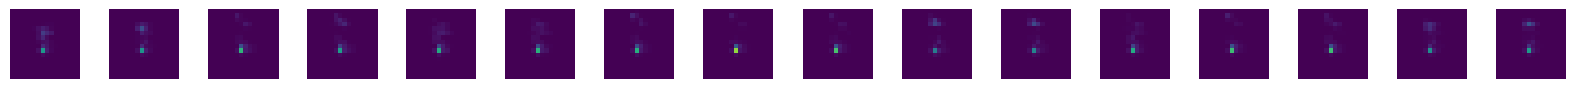

[Epoch 13/30] [D loss: 0.5698] [G loss: 0.3993] [Validity_loss: 0.3868] 
 [Stat_loss: 0.0452] [NNZ_loss: 0.0114]
Sample feature coding: [ 1.         -0.96480787 -0.01191316  0.25846905  0.6470616   0.00740768
  0.066674    0.00399931  0.02120699]


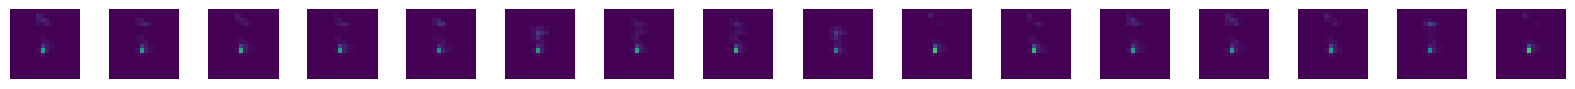

[Epoch 14/30] [D loss: 0.6480] [G loss: 0.2155] [Validity_loss: 0.3932] 
 [Stat_loss: 0.0454] [NNZ_loss: 0.0117]
Sample feature coding: [0.         0.64234513 0.7590015  0.41957    0.6476869  0.00994504
 0.05480777 0.00398019 0.01583003]


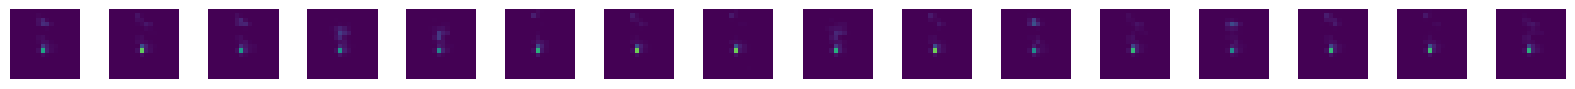

[Epoch 15/30] [D loss: 0.6094] [G loss: 0.4100] [Validity_loss: 0.3821] 
 [Stat_loss: 0.0454] [NNZ_loss: 0.0111]
Sample feature coding: [ 0.         -1.1746716   0.3786647   0.4591298   0.5857908   0.01000331
  0.0570684   0.00352965  0.02178754]


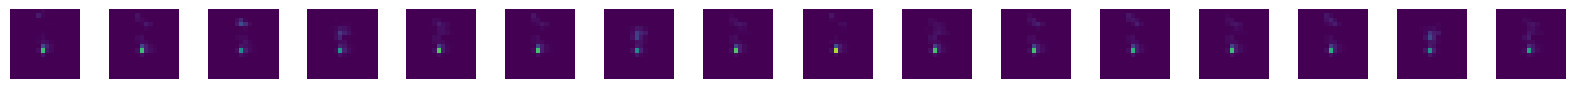

[Epoch 16/30] [D loss: 0.4871] [G loss: 0.3822] [Validity_loss: 0.3776] 
 [Stat_loss: 0.1200] [NNZ_loss: 0.0133]
Sample feature coding: [ 0.         -0.07911825  0.6654315   0.17868897  0.42843705  0.01224778
  0.06721471  0.00372696  0.02061651]


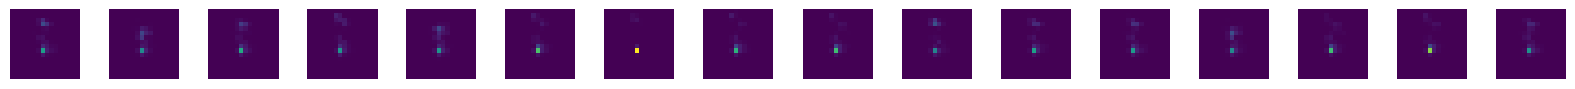

[Epoch 17/30] [D loss: 0.7522] [G loss: 0.2217] [Validity_loss: 0.3782] 
 [Stat_loss: 0.0512] [NNZ_loss: 0.0122]
Sample feature coding: [ 0.         -0.42114246  0.62682295  0.3004953   0.95610887  0.01061599
  0.03287309  0.00362653  0.01807311]


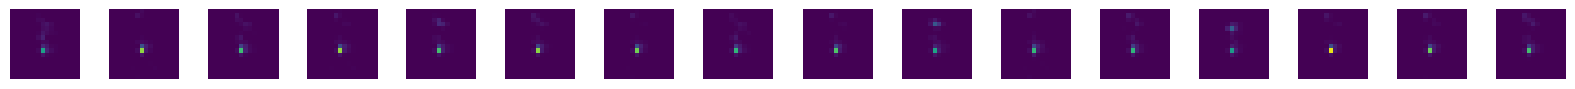

[Epoch 18/30] [D loss: 0.4934] [G loss: 0.2352] [Validity_loss: 0.4036] 
 [Stat_loss: 0.0455] [NNZ_loss: 0.0123]
Sample feature coding: [ 1.         -1.5583378   0.9185067   0.5206035   0.57842124  0.00998924
  0.05903374  0.00398098  0.03589856]


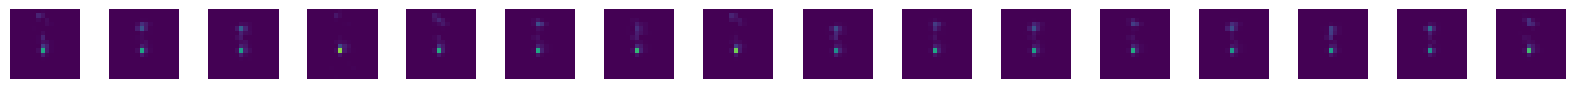

[Epoch 19/30] [D loss: 0.4603] [G loss: 0.2537] [Validity_loss: 0.4031] 
 [Stat_loss: 0.0654] [NNZ_loss: 0.0083]
Sample feature coding: [ 1.         -1.5393637   0.60617596  0.5931479   0.5817979   0.01092687
  0.04857119  0.00381217  0.03782794]


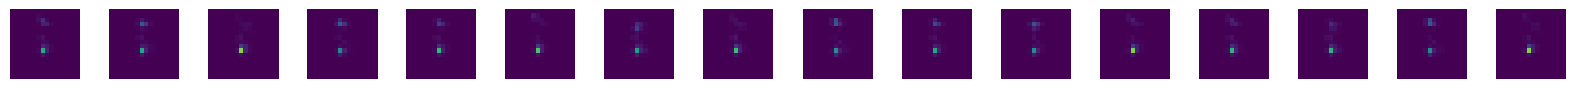

[Epoch 20/30] [D loss: 0.5346] [G loss: 0.3808] [Validity_loss: 0.3716] 
 [Stat_loss: 0.0453] [NNZ_loss: 0.0113]
Sample feature coding: [1.         0.492753   0.44201264 0.65075654 0.8892314  0.00834584
 0.03327667 0.00359067 0.023151  ]


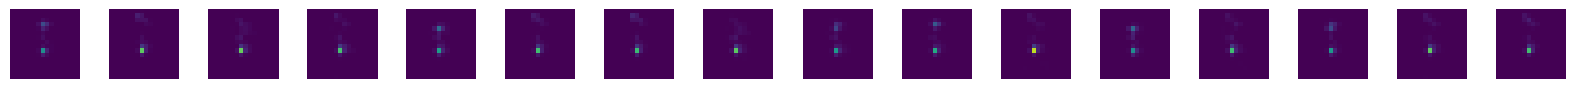

[Epoch 21/30] [D loss: 0.6099] [G loss: 0.2226] [Validity_loss: 0.3716] 
 [Stat_loss: 0.0455] [NNZ_loss: 0.0112]
Sample feature coding: [1.         1.7081226  0.4115421  0.51933974 0.34790018 0.01014054
 0.04624492 0.00400149 0.02897792]


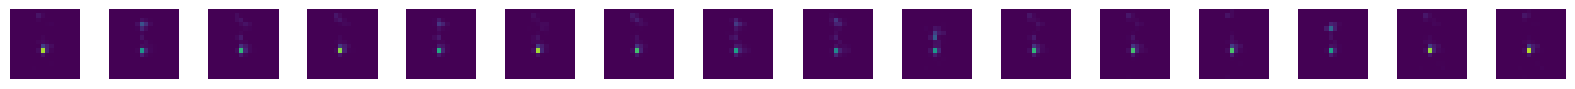

[Epoch 22/30] [D loss: 0.3827] [G loss: 0.2946] [Validity_loss: 0.3690] 
 [Stat_loss: 0.0454] [NNZ_loss: 0.0104]
Sample feature coding: [1.         0.6921935  0.8209262  0.67369574 0.5949805  0.01063221
 0.04334643 0.00391074 0.02255124]


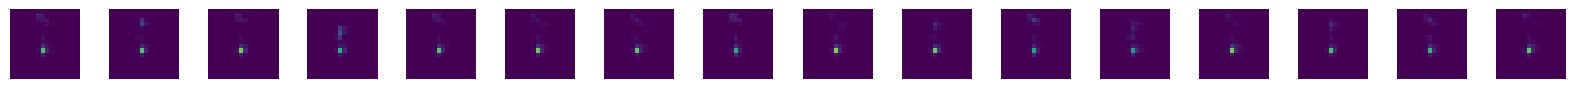

[Epoch 23/30] [D loss: 0.6216] [G loss: 0.2853] [Validity_loss: 0.3454] 
 [Stat_loss: 0.0454] [NNZ_loss: 0.0114]
Sample feature coding: [0.         2.0699062  0.11208322 0.15091632 0.63266635 0.00945862
 0.05763784 0.00402707 0.02711119]


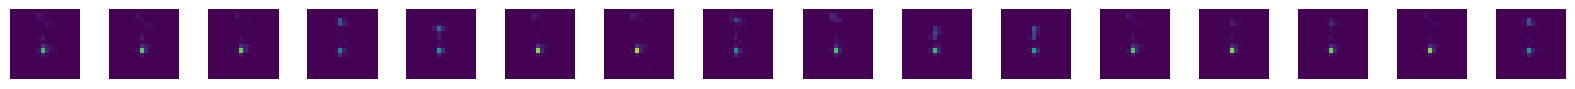

[Epoch 24/30] [D loss: 0.6541] [G loss: 0.2182] [Validity_loss: 0.3376] 
 [Stat_loss: 0.0453] [NNZ_loss: 0.0114]
Sample feature coding: [ 0.         -0.3548038   0.20025812  0.8752547   0.76517135  0.01256626
  0.09785392  0.00366664  0.02921137]


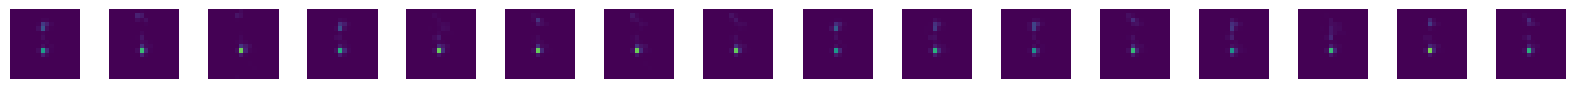

[Epoch 25/30] [D loss: 0.4486] [G loss: 0.2865] [Validity_loss: 0.3462] 
 [Stat_loss: 0.0453] [NNZ_loss: 0.0112]
Sample feature coding: [0.         1.0420682  0.17583238 0.4549572  0.59498864 0.00898971
 0.05196747 0.00365928 0.03014062]


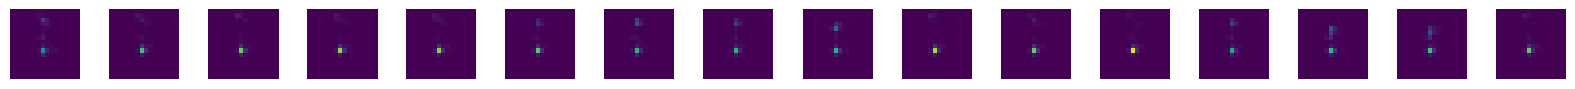

[Epoch 26/30] [D loss: 0.4267] [G loss: 0.4066] [Validity_loss: 0.3482] 
 [Stat_loss: 0.0452] [NNZ_loss: 0.0117]
Sample feature coding: [ 1.         -0.5335049   0.27540287  0.06527622  0.51546395  0.01144704
  0.02896521  0.00368269  0.02510007]


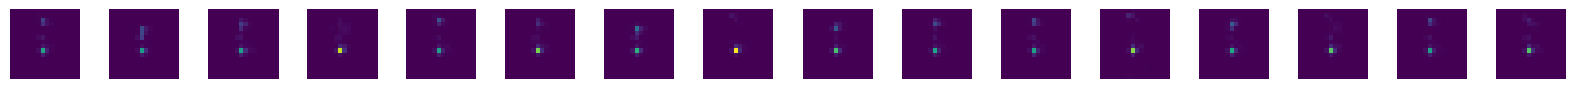

[Epoch 27/30] [D loss: 0.4036] [G loss: 0.2692] [Validity_loss: 0.3445] 
 [Stat_loss: 0.1355] [NNZ_loss: 0.0150]
Sample feature coding: [ 0.         -0.41972572  0.21251148  0.43263713  0.513101    0.00905481
  0.06990976  0.00361392  0.02424974]


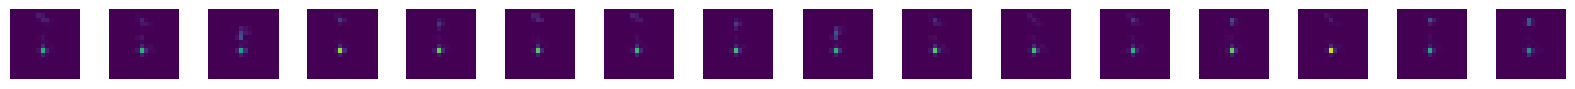

[Epoch 28/30] [D loss: 0.4425] [G loss: 0.3769] [Validity_loss: 0.3257] 
 [Stat_loss: 0.0454] [NNZ_loss: 0.0105]
Sample feature coding: [ 0.         -0.4901289   0.01881715  0.19389059  0.46951717  0.00819113
  0.04005377  0.00347786  0.02367136]


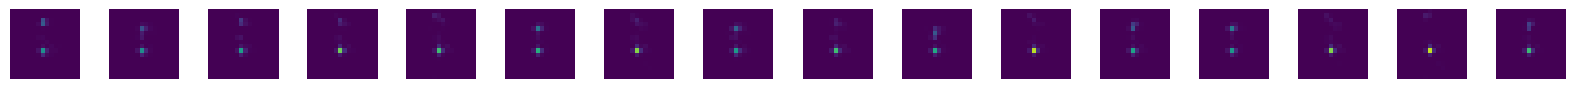

[Epoch 29/30] [D loss: 0.4831] [G loss: 0.2534] [Validity_loss: 0.3344] 
 [Stat_loss: 0.0454] [NNZ_loss: 0.0118]
Sample feature coding: [0.         1.1359814  0.26487917 0.346007   0.668855   0.00987195
 0.07184485 0.00418164 0.02369355]


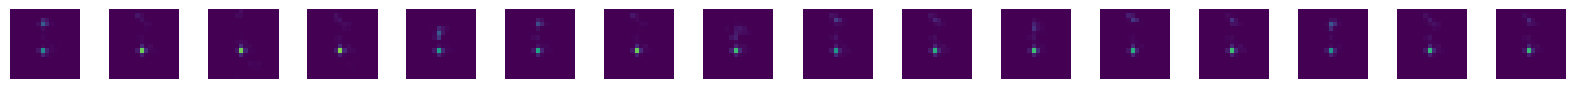

[Epoch 30/30] [D loss: 0.5434] [G loss: 0.2284] [Validity_loss: 0.3302] 
 [Stat_loss: 0.0448] [NNZ_loss: 0.0118]
Sample feature coding: [1.         0.47231725 0.42181298 0.5819782  0.66230243 0.01108022
 0.04352664 0.00414806 0.01469166]


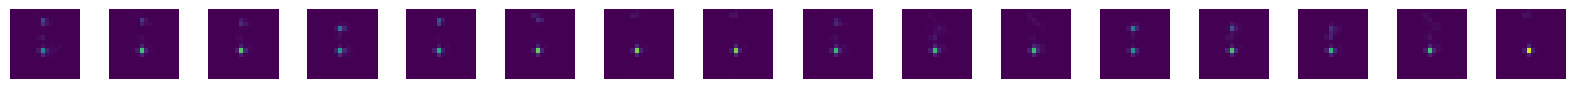

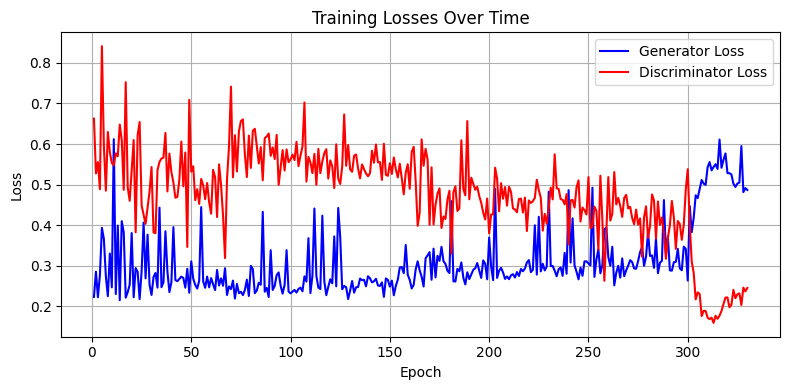

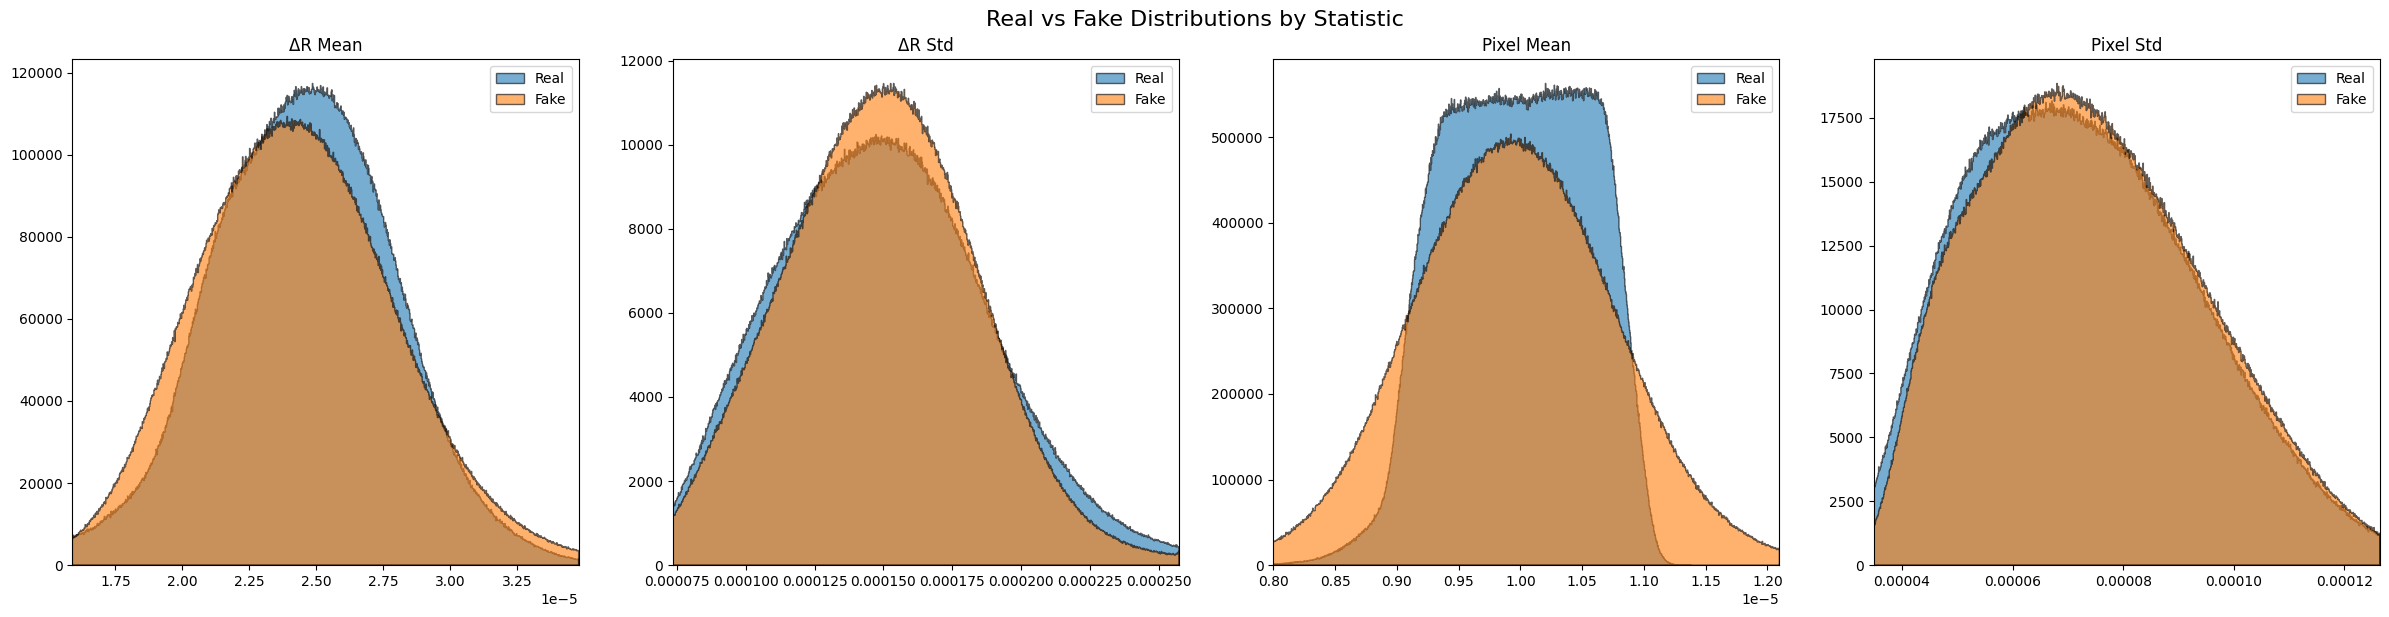

In [13]:
for epoch in range(n_epochs):
    for i, (real_image, real_features, flipped_image, flipped_features) in enumerate(dataloader):
        
        # All real data are normalized in the dataloader
        real_feat = real_features.cuda()
        real_flipped_feat = flipped_features.cuda()
        real_img = real_image.unsqueeze(1).cuda()
        real_flipped_img = flipped_image.unsqueeze(1).cuda()

        # print(f"Real: {real_img.shape}")

        # Codings should be label, eta, pT, mass that get passed directly to the discriminator
        # Other values are pure noise and get passed to the generator, then those outputs passed to the discriminator

        # Discriminator training
        if i % 2 == 0:
            optimizer_D.zero_grad()
            discriminator.train()
            # Generate fake samples
            # Should be very easy to modify which values are passed as codings
            z_codings = torch.cat([torch.randint(0, 2, (batch_size, 1)), 
                                  sample_fit_noise(kdes, num_samples=batch_size)[:,:]],
                                  dim=1).cuda()
            # z_noise = torch.randn(batch_size, 5, ).cuda()
            # z_codings = torch.cat([z_codings, z_noise], dim=1)

            # Discriminator gets z_codings + generated_features
            fake_img = generator(z_codings)
            # print(f"Fake: {fake_img.shape}")

            # Generate eta-flipped data
            flipped_z_codings = z_codings.clone()
            flipped_z_codings[:, 1] *= -1
            
            fake_flipped_img = generator(flipped_z_codings)

            # Get predictions and labels
            real_disc_codings = real_feat[:,:num]
            real_flipped_disc_codings = real_flipped_feat[:,:num]
            fake_disc_codings = z_codings[:,:num]
            fake_flipped_disc_codings = flipped_z_codings[:,:num]

            real_pred = discriminator(real_img, real_disc_codings)
            real_flipped_pred = discriminator(real_flipped_img, real_flipped_disc_codings)
            fake_pred = discriminator(fake_img, fake_disc_codings)
            fake_flipped_pred = discriminator(fake_flipped_img, fake_flipped_disc_codings)

            preds = (torch.cat([real_pred, real_flipped_pred, fake_pred, fake_flipped_pred], dim=0)).squeeze(1)


            # real_labels = torch.empty_like(real_pred).uniform_(0.7, 1.2)
            # fake_labels = torch.empty_like(fake_pred).uniform_(0.0, 0.3)
            # labels = (torch.cat([real_labels, fake_labels], dim=0)).cuda()

            ones = torch.ones(2*len(fake_pred))
            zeros = torch.zeros(2*len(real_pred))
            labels = (torch.cat([ones, zeros], dim=0)).cuda()

            # Discriminator loss is just its ability to distinguish
            d_loss = torch.nn.BCELoss()(preds, labels)

            d_loss.backward()
            optimizer_D.step()

        # Generator Training
        if i % 1 == 0:
            optimizer_G.zero_grad()
            # generator.train()
            
            # Generate fake data
            # Should be very easy to modify which values are passed as codings
            z_codings = torch.cat([torch.randint(0, 2, (batch_size, 1)), 
                                  sample_fit_noise(kdes, num_samples=batch_size)[:,:]],
                                  dim=1).cuda()
            # z_noise = torch.randn(batch_size, 5, ).cuda()
            # z_codings = torch.cat([z_codings, z_noise], dim=1)

            # Discriminator gets z_codings + generated_features
            fake_img = generator(z_codings)

            # Generate eta-flipped data
            flipped_z_codings = z_codings.clone()
            flipped_z_codings[:, 1] *= -1
            
            fake_flipped_img = generator(flipped_z_codings)

            # Get predictions and labels
            fake_disc_codings = z_codings[:,:num]
            fake_flipped_disc_codings = flipped_z_codings[:,:num]
            
            # Fooled discriminator loss
            d_out = discriminator(fake_img, fake_disc_codings)
            d_out_flip = discriminator(fake_flipped_img, fake_flipped_disc_codings)
            real_pred = discriminator(real_img, real_disc_codings)
            real_flipped_pred = discriminator(real_flipped_img, real_flipped_disc_codings)
            
            target = torch.ones_like(d_out)
            bce = nn.BCELoss()
            validity_loss = bce(d_out, target) + bce(d_out_flip, target)

            # ----- Fake ΔR Calculation -----
            # Original
            # Weighted: pixel * distance / sum(pixel)
            weights = fake_img.squeeze(1)

            dR = (weights * dists)

            fake_dR_mean = dR.mean(dim = (1,2))
            fake_dR_std = dR.std(dim = (1,2))
            
            # Pixel stats
            fake_pixel_mean = weights.mean(dim = (1,2))
            fake_pixel_std = weights.std(dim = (1,2))
            
            # Flipped
            # Weighted: pixel * distance / sum(pixel)
            weights = fake_flipped_img.squeeze(1)
            dR = (weights * dists)

            flipped_dR_mean = dR.mean(dim = (1,2))
            flipped_dR_std = dR.std(dim = (1,2))
            
            # Pixel stats
            flipped_pixel_mean = weights.squeeze(1).mean(dim = (1,2))
            flipped_pixel_std = weights.squeeze(1).std(dim = (1,2))

            real_dR_mean = z_codings[:,5]
            real_dR_std = z_codings[:,6]
            real_pixel_mean = z_codings[:,7]
            real_pixel_std = z_codings[:,8]


            # Statistical MSE loss
            # dR_mean_loss = (torch.nn.MSELoss()(fake_dR_mean, real_dR_mean) + torch.nn.MSELoss()(flipped_dR_mean, real_dR_mean))
            # dR_std_loss = (torch.nn.MSELoss()(fake_dR_std, real_dR_std) + torch.nn.MSELoss()(flipped_dR_std, real_dR_std))
            # pixel_mean_loss = (torch.nn.MSELoss()(fake_pixel_mean, real_pixel_mean) + torch.nn.MSELoss()(flipped_pixel_mean, real_pixel_mean))
            # pixel_std_loss = (torch.nn.MSELoss()(fake_pixel_std, real_pixel_std) + torch.nn.MSELoss()(flipped_pixel_std, real_pixel_std))
            
            # stat_loss = dR_mean_loss + dR_std_loss + 3*pixel_mean_loss + 2*pixel_std_loss

            # print(dR_mean_loss)
            # print(dR_std_loss)
            # print(3*pixel_mean_loss)
            # print(2*pixel_std_loss)

            # Statistical KL Divergence loss
            kl_total = 0
            kl_total += kde_kl_divergence_torch(real_dR_mean, fake_dR_mean) / .001
            kl_total += kde_kl_divergence_torch(real_dR_std, fake_dR_std) / .04
            kl_total += kde_kl_divergence_torch(real_pixel_mean, fake_pixel_mean) / .00006
            kl_total += kde_kl_divergence_torch(real_pixel_std, fake_pixel_std) / .007

            stat_loss = kl_total

            # Number non-zero loss
            fake_nnz = soft_count_nonzero(fake_img, threshold=3e-3, sharpness=10000.0)
            real_nnz = soft_count_nonzero(real_img, threshold=3e-3, sharpness=10000.0)
            nnz_loss = torch.nn.MSELoss()(fake_nnz, real_nnz)

            
            # Total generator loss is the average of the discriminator's predictions of the original and flipped data
            # + the difference between input and output dR and pixel statistics

            alpha = .05
            beta = .00005
            chi = .001

            g_loss = (alpha*validity_loss + beta*nnz_loss + chi*stat_loss) + .1

            g_loss.backward()
            optimizer_G.step()

            if n_epochs - epoch <= 10:
                # Track fake stats
                tracked_fake_dR_mean.append(fake_dR_mean.detach().cpu())
                tracked_fake_dR_std.append(fake_dR_std.detach().cpu())
                tracked_fake_pixel_mean.append(fake_pixel_mean.detach().cpu())
                tracked_fake_pixel_std.append(fake_pixel_std.detach().cpu())
                
                # Track real stats from z_codings
                tracked_real_dR_mean.append(z_codings[:,5].detach().cpu())
                tracked_real_dR_std.append(z_codings[:,6].detach().cpu())
                tracked_real_pixel_mean.append(z_codings[:,7].detach().cpu())
                tracked_real_pixel_std.append(z_codings[:,8].detach().cpu())

    g_losses.append(g_loss.item())
    d_losses.append(d_loss.item())

    print(f"[Epoch {epoch+1}/{n_epochs}] [D loss: {d_losses[epoch]:.4f}] [G loss: {g_losses[epoch]:.4f}] [Validity_loss: {alpha*validity_loss:.4f}] \n [Stat_loss: {chi*stat_loss:.4f}] [NNZ_loss: {beta*nnz_loss:.4f}]") 

    z_img = torch.randn(batch_size, 256, 1, 1).cuda()

    # Should be very easy to modify which values are passed as codings
    z_codings = torch.cat([torch.randint(0, 2, (batch_size, 1)), 
                          sample_fit_noise(kdes, num_samples=batch_size)],
                          dim=1).cuda()
    # z_noise = torch.randn(batch_size, 5, ).cuda()
    # z_feat1 = torch.cat([z_codings, z_noise], dim=1)
    z_feat = torch.cat([z_codings], dim=1)

    fake_images = generator(z_feat)
    fake_feat = z_codings
    fake_images.detach().cpu()
    fake_feat.detach().cpu()
    # real_images = next(iter(dataloader))[0][:1000].cpu()

    # output_image = fake_images[:16]  # Save 16 generated samples
    # output_image = (output_image + 1) / 2.0  # Scale to [0, 1]
    # grid = (torchvision.utils.make_grid(output_image, nrow=4, normalize=True)).cpu()
    # np_img = grid.permute(1, 2, 0).numpy()
    # plt.imsave(f'classical_Jet_image_epoch_{epoch}.png', np_img)
    plot_generated_samples(generator, dataset, kdes, batch_size=16, latent_dim=256)

plot_metrics(g_losses, d_losses)

## Last 10 epochs stats
# Flatten all batches
fake_dR_mean_vals = torch.cat(tracked_fake_dR_mean).numpy() / batch_size
fake_dR_std_vals = torch.cat(tracked_fake_dR_std).numpy() / batch_size
fake_pixel_mean_vals = torch.cat(tracked_fake_pixel_mean).numpy() / batch_size
fake_pixel_std_vals = torch.cat(tracked_fake_pixel_std).numpy() / batch_size

real_dR_mean_vals = torch.cat(tracked_real_dR_mean).numpy() / batch_size
real_dR_std_vals = torch.cat(tracked_real_dR_std).numpy() / batch_size
real_pixel_mean_vals = torch.cat(tracked_real_pixel_mean).numpy() / batch_size
real_pixel_std_vals = torch.cat(tracked_real_pixel_std).numpy() / batch_size

fig, axs = plt.subplots(1, 4, figsize=(24, 6))  # 4 stats

stat_titles = ['ΔR Mean', 'ΔR Std', 'Pixel Mean', 'Pixel Std']
real_stats = [real_dR_mean_vals, real_dR_std_vals, real_pixel_mean_vals, real_pixel_std_vals]
fake_stats = [fake_dR_mean_vals, fake_dR_std_vals, fake_pixel_mean_vals, fake_pixel_std_vals]

for row in range(4):
    ax = axs[row]

    real_vals = real_stats[row]
    fake_vals = fake_stats[row]

    # Compute limits
    lower = min(np.percentile(real_vals, 1), np.percentile(fake_vals, 1))
    upper = max(np.percentile(real_vals, 99), np.percentile(fake_vals, 99))

    # Truncate values
    real_vals_trunc = real_vals[(real_vals >= lower) & (real_vals <= upper)]
    fake_vals_trunc = fake_vals[(fake_vals >= lower) & (fake_vals <= upper)]

    # Plot
    ax.hist(real_vals_trunc, bins=1000, alpha=0.6, label='Real',
            edgecolor='black', density=True, histtype='stepfilled')
    ax.hist(fake_vals_trunc, bins=1000, alpha=0.6, label='Fake',
            edgecolor='black', density=True, histtype='stepfilled')

    ax.set_xlim(lower, upper)
    ax.set_title(f"{stat_titles[row]}")
    ax.legend()

plt.tight_layout()
plt.suptitle("Real vs Fake Distributions by Statistic", fontsize=16, y=1.02)
plt.show()


In [ ]:
## Save Model
# Create output directory if it doesn't exist
os.makedirs("models", exist_ok=True)

# Timestamp for unique filenames
timestamp = datetime.now().strftime("m%d_%H%M)

# Save model states and tracked data in a single file
save_path = f"models/class_gan_short_model_{timestamp}.pt"
torch.save({
    "generator_state_dict": generator.state_dict(),
    "discriminator_state_dict": discriminator.state_dict(),
    "g_losses": g_losses,
    "d_losses": d_losses,
    "tracked_fake_dR_mean": tracked_fake_dR_mean,
    "tracked_fake_dR_std": tracked_fake_dR_std,
    "tracked_fake_pixel_mean": tracked_fake_pixel_mean,
    "tracked_fake_pixel_std": tracked_fake_pixel_std,
    "tracked_real_dR_mean": tracked_real_dR_mean,
    "tracked_real_dR_std": tracked_real_dR_std,
    "tracked_real_pixel_mean": tracked_real_pixel_mean,
    "tracked_real_pixel_std": tracked_real_pixel_std
}, save_path)

print(f"Model and statistics saved to {save_path}")

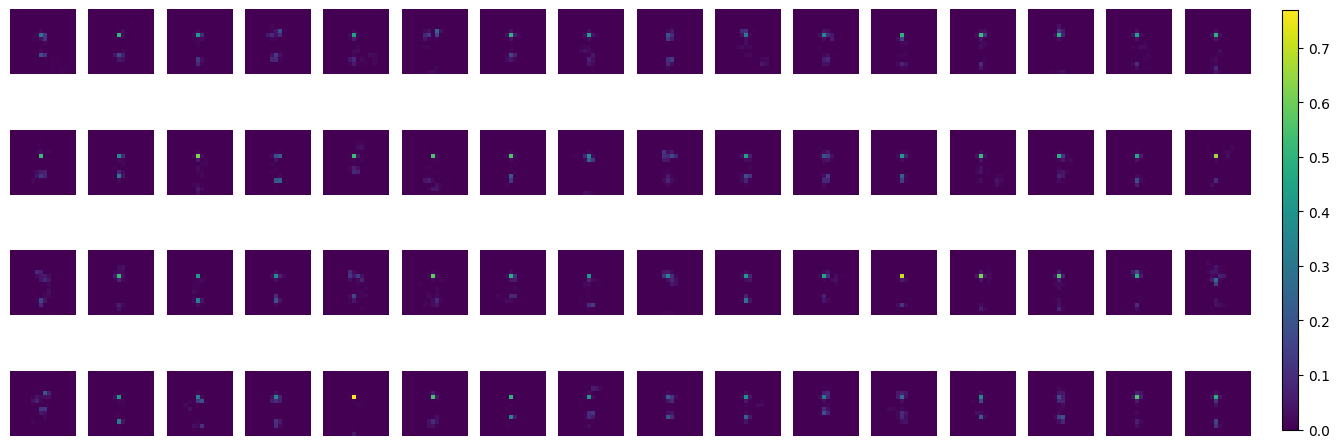

In [14]:
n_rows, n_cols = 4, 16
n_images = n_rows * n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows * 1.5))

vmin = dataset.images[:n_images].min()
vmax = dataset.images[:n_images].max()

# Show images and keep the first imshow object for colorbar
im = None
for i in range(n_images):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]
    im = ax.imshow(dataset.images[i], cmap='viridis', vmin=vmin, vmax=vmax)
    ax.axis('off')

# Add a single colorbar on the right of the grid
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax)

plt.show()

Sample feature coding: [1.         0.20388874 0.3871602  0.8565075  0.56074417 0.01036377
 0.07304595 0.00384679 0.03621174]


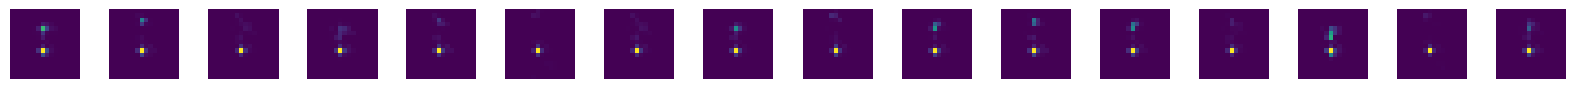

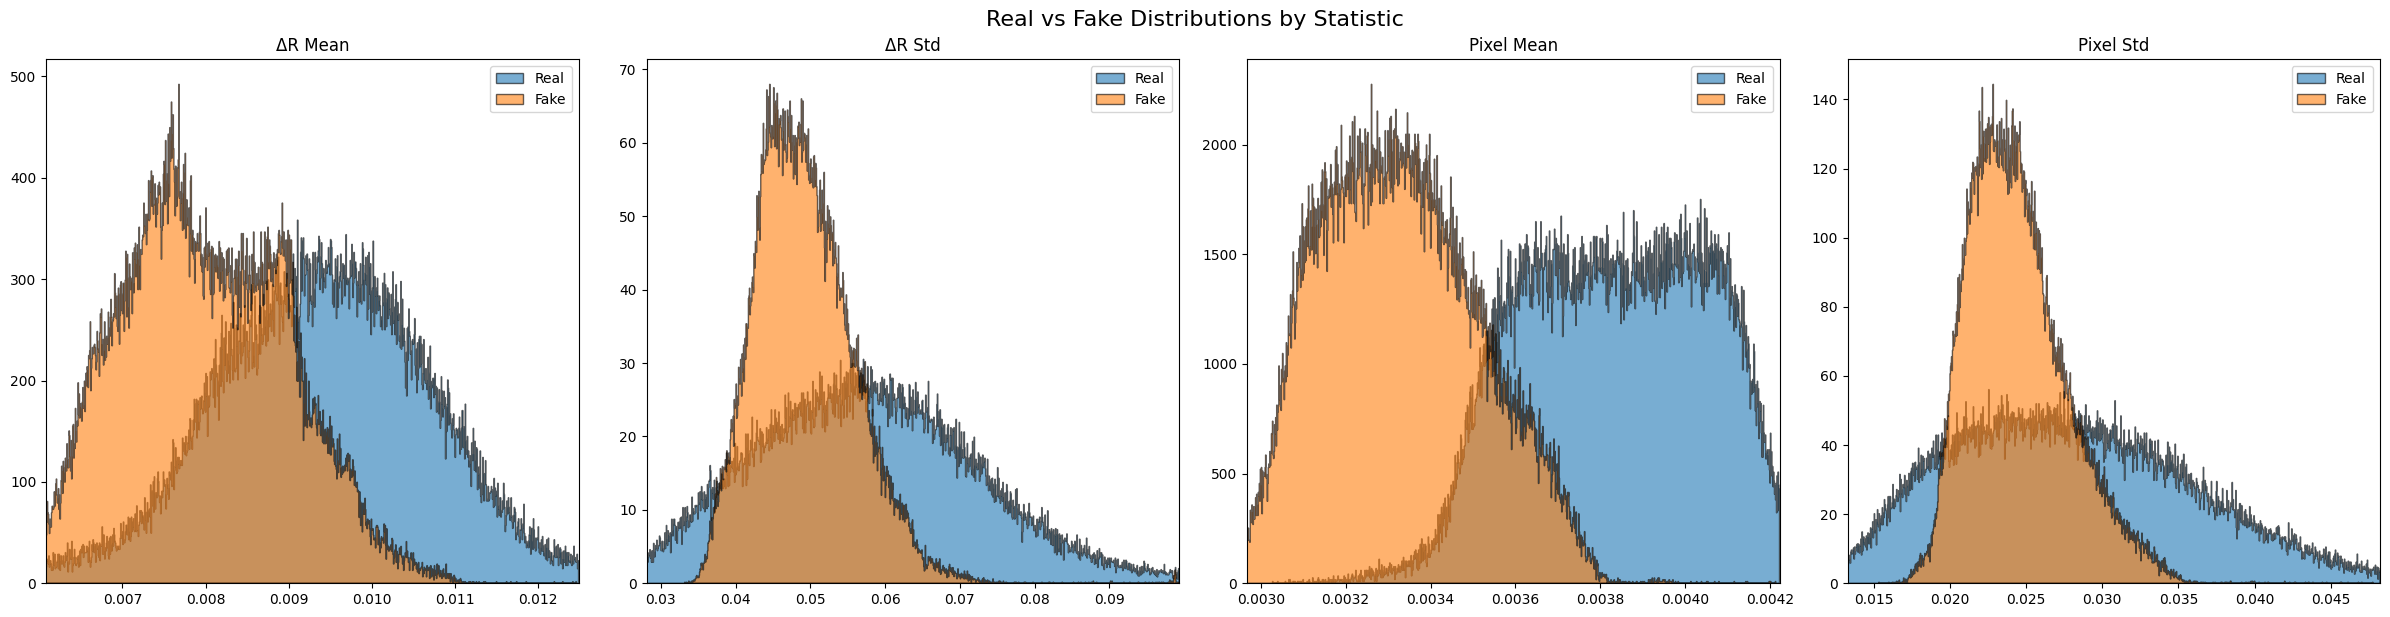

Discriminator output (wrong label): [0.99984765 0.37036648 0.99569476 ... 0.48868805 1.         0.99880636]
Discriminator output (correct label): [0.9998919  0.8488182  0.99903774 ... 0.9354145  1.         0.9992119 ]
Real labels: [1. 1. 1. ... 1. 1. 1.]
Swapped labels: [0. 0. 0. ... 0. 0. 0.]
Relative change (%): [-4.4226646e-03 -5.6366806e+01 -3.3462048e-01 ... -4.7757061e+01
  0.0000000e+00 -4.0584803e-02]


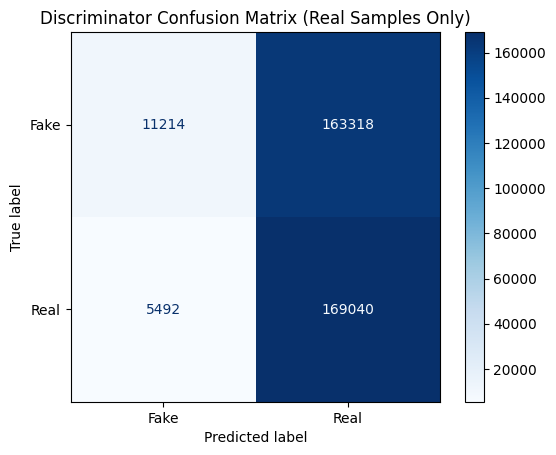

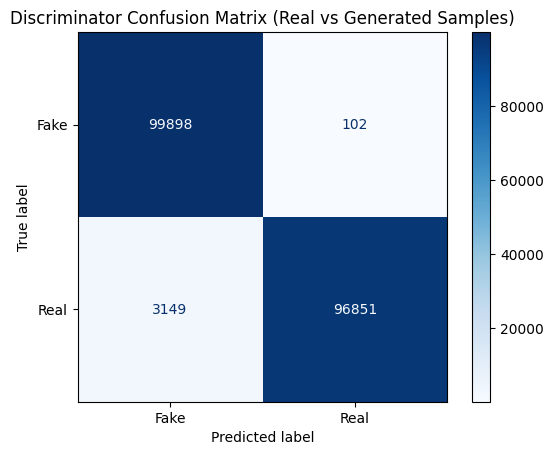

In [15]:
test_generated_samples(generator, discriminator, dataset, kdes, batch_size=100000)

# Optional args:
#     generator,
#     discriminator,
#     dataset,
#     kdes,
#     batch_size=16,
#     latent_dim=256,
#     codings=None,
#     plot_distributions=True,
#     compare_discriminator=True